# Application Fraud Detection

This notebook demonstrates the complete pipeline used to develop a machine learning model for detecting fraudulent or suspicious applications.

To ensure better reproducibility and modularity, the core stages—data preparation, training, and evaluation—are implemented here. Model tracking and registration with MLflow, as well as MLOps automation (retraining, version control, deployment), are handled separately in dedicated Python scripts.

Each main section in this notebook is independent and can be run on its own, assuming the required inputs (e.g. cleaned dataset, saved model) are available. This structure allows for flexible experimentation. Be sure to import all necessary libraries and modules before executing a section.

Notebook Structure:
1. Dataset loading and pre-cleaning
2.	Model training and evaluation
3.	Model testing

In [31]:
# Standard library
import os
import zipfile
import json

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier

# Model persistence
import joblib

# MLflow for model tracking
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

## Section 1: Dataset loading and pre-cleaning

This section loads the original datasets: application_data.csv and previous_application.csv.

Key steps:
- Drop irrelevant columns and fix data types
- Handle missing values
- Aggregate previous applications at customer level
- Merge both datasets into a unified structure

The final cleaned dataset is saved as final_cleaned_data.csv and used in Section 2.

### Section 1.1: Load and merge application datasets

In [2]:
# Load main application data (application_data.csv)
df_main = pd.read_csv("data/application_data.csv")
print("Loaded: application_data.csv as df_main")

# Load previous application data (previous_application.csv)
df_prev = pd.read_csv("data/previous_application.csv")
print("Loaded: previous_application.csv as df_prev")

Loaded: application_data.csv as df_main
Loaded: previous_application.csv as df_prev


In [3]:
# Columns to keep (application_data)
columns_main = [
    'SK_ID_CURR',
    'TARGET',
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'CNT_CHILDREN',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'OCCUPATION_TYPE',
    'CNT_FAM_MEMBERS',
    'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE',
    'FLAG_EMAIL',
    'REGION_RATING_CLIENT',
    'REG_REGION_NOT_LIVE_REGION',
    'ORGANIZATION_TYPE'
]

df_main = df_main[columns_main]

In [4]:
# Columns to keep (previous_application)
columns_prev = [
    'SK_ID_CURR',
    'AMT_CREDIT',
    'NFLAG_LAST_APPL_IN_DAY',
    'NAME_CONTRACT_STATUS',
    'DAYS_DECISION',
    'NAME_CLIENT_TYPE',
    'CNT_PAYMENT'
]

df_prev = df_prev[columns_prev]

In [5]:
# One-hot encode categorical columns (df_prev)
df_prev = pd.get_dummies(df_prev, columns=['NAME_CONTRACT_STATUS', 'NAME_CLIENT_TYPE'])

# Group by SK_ID_CURR and aggregate
df_prev_agg = df_prev.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT': ['mean', 'max'],
    'CNT_PAYMENT': 'mean',
    'NFLAG_LAST_APPL_IN_DAY': 'sum',
    'DAYS_DECISION': 'mean',
    'NAME_CONTRACT_STATUS_Approved': 'sum',
    'NAME_CONTRACT_STATUS_Refused': 'sum',
    'NAME_CONTRACT_STATUS_Canceled': 'sum',
    'NAME_CONTRACT_STATUS_Unused offer': 'sum',
    'NAME_CLIENT_TYPE_New': 'sum',
    'NAME_CLIENT_TYPE_Repeater': 'sum',
    'NAME_CLIENT_TYPE_Refreshed': 'sum',
    'NAME_CLIENT_TYPE_XNA': 'sum'
}).reset_index()

# Flatten column names
df_prev_agg.columns = ['SK_ID_CURR'] + [f'PREV_{col[0]}_{col[1]}' for col in df_prev_agg.columns[1:]]

In [6]:
# Merge aggregated previous application data with main application data
df_merged = df_main.merge(df_prev_agg, on='SK_ID_CURR', how='left')

In [8]:
# Save merged dataset to CSV
df_merged.to_csv("data/merged_application_data.csv", index=False)

### Section 1.2: Dataset overview

In [9]:
# Read file (merged_application_data.csv)
df_merged = pd.read_csv("data/merged_application_data.csv")

In [10]:
df_merged.shape

(307511, 40)

In [11]:
df_merged.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREV_NFLAG_LAST_APPL_IN_DAY_sum,PREV_DAYS_DECISION_mean,PREV_NAME_CONTRACT_STATUS_Approved_sum,PREV_NAME_CONTRACT_STATUS_Refused_sum,PREV_NAME_CONTRACT_STATUS_Canceled_sum,PREV_NAME_CONTRACT_STATUS_Unused offer_sum,PREV_NAME_CLIENT_TYPE_New_sum,PREV_NAME_CLIENT_TYPE_Repeater_sum,PREV_NAME_CLIENT_TYPE_Refreshed_sum,PREV_NAME_CLIENT_TYPE_XNA_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,1.0,-606.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,3.0,-1305.000000,3.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,1.0,-815.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,9.0,-272.444444,5.0,1.0,3.0,0.0,1.0,8.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,6.0,-1222.833333,6.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0


In [12]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   SK_ID_CURR                                  307511 non-null  int64  
 1   TARGET                                      307511 non-null  int64  
 2   NAME_CONTRACT_TYPE                          307511 non-null  object 
 3   CODE_GENDER                                 307511 non-null  object 
 4   FLAG_OWN_CAR                                307511 non-null  object 
 5   FLAG_OWN_REALTY                             307511 non-null  object 
 6   CNT_CHILDREN                                307511 non-null  int64  
 7   AMT_INCOME_TOTAL                            307511 non-null  float64
 8   AMT_CREDIT                                  307511 non-null  float64
 9   AMT_ANNUITY                                 307499 non-null  float64
 

In [13]:
df_merged.nunique()

SK_ID_CURR                                    307511
TARGET                                             2
NAME_CONTRACT_TYPE                                 2
CODE_GENDER                                        3
FLAG_OWN_CAR                                       2
FLAG_OWN_REALTY                                    2
CNT_CHILDREN                                      15
AMT_INCOME_TOTAL                                2548
AMT_CREDIT                                      5603
AMT_ANNUITY                                    13672
AMT_GOODS_PRICE                                 1002
NAME_INCOME_TYPE                                   8
NAME_EDUCATION_TYPE                                5
NAME_FAMILY_STATUS                                 6
NAME_HOUSING_TYPE                                  6
DAYS_BIRTH                                     17460
DAYS_EMPLOYED                                  12574
DAYS_REGISTRATION                              15688
OCCUPATION_TYPE                               

In [14]:
df_merged.isnull().sum()[df_merged.isnull().sum() > 0]

AMT_ANNUITY                                      12
AMT_GOODS_PRICE                                 278
OCCUPATION_TYPE                               96391
CNT_FAM_MEMBERS                                   2
PREV_AMT_CREDIT_mean                          16454
PREV_AMT_CREDIT_max                           16454
PREV_CNT_PAYMENT_mean                         16869
PREV_NFLAG_LAST_APPL_IN_DAY_sum               16454
PREV_DAYS_DECISION_mean                       16454
PREV_NAME_CONTRACT_STATUS_Approved_sum        16454
PREV_NAME_CONTRACT_STATUS_Refused_sum         16454
PREV_NAME_CONTRACT_STATUS_Canceled_sum        16454
PREV_NAME_CONTRACT_STATUS_Unused offer_sum    16454
PREV_NAME_CLIENT_TYPE_New_sum                 16454
PREV_NAME_CLIENT_TYPE_Repeater_sum            16454
PREV_NAME_CLIENT_TYPE_Refreshed_sum           16454
PREV_NAME_CLIENT_TYPE_XNA_sum                 16454
dtype: int64

In [15]:
df_merged.duplicated().sum()

0

In [16]:
# Value counts for categorical columns
for col in df_merged.columns:
    if df_merged[col].dtype == 'object':
        print(f"\nValue counts for column: {col}")
        print(df_merged[col].value_counts(dropna=False))


Value counts for column: NAME_CONTRACT_TYPE
NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64

Value counts for column: CODE_GENDER
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

Value counts for column: FLAG_OWN_CAR
FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64

Value counts for column: FLAG_OWN_REALTY
FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtype: int64

Value counts for column: NAME_INCOME_TYPE
NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64

Value counts for column: NAME_EDUCATION_TYPE
NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower seco

In [17]:
df_merged[[
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'PREV_AMT_CREDIT_mean',
    'PREV_AMT_CREDIT_max',
    'PREV_DAYS_DECISION_mean'
    ]].describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION,PREV_AMT_CREDIT_mean,PREV_AMT_CREDIT_max,PREV_DAYS_DECISION_mean
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,2.910570e+05,2.910570e+05,291057.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,63815.045904,-4986.120328,1.700700e+05,4.138656e+05,-919.574157
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,141275.766519,3522.886321,1.657372e+05,4.575384e+05,577.765937
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,-17912.000000,-24672.000000,0.000000e+00,0.000000e+00,-2922.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,-2760.000000,-7479.500000,6.684943e+04,1.044315e+05,-1247.000000
50%,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,-1213.000000,-4504.000000,1.174500e+05,2.250000e+05,-789.000000
75%,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,-289.000000,-2010.000000,2.160720e+05,5.473440e+05,-466.800000
max,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,365243.000000,0.000000,4.050000e+06,4.509688e+06,-2.000000


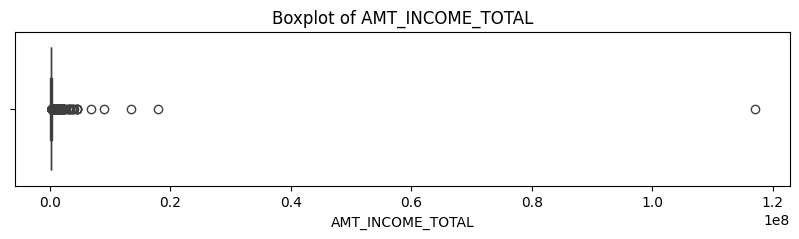

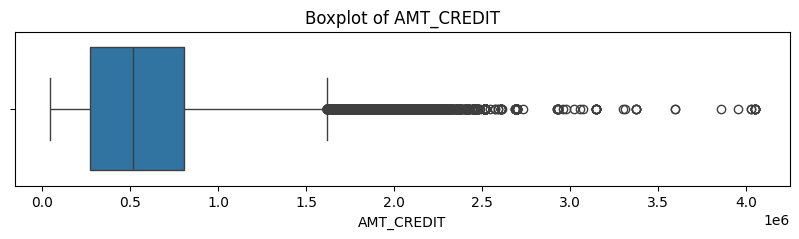

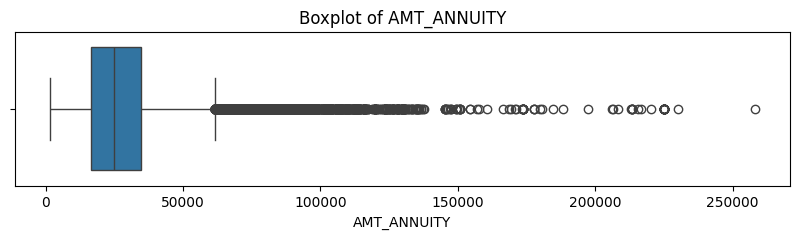

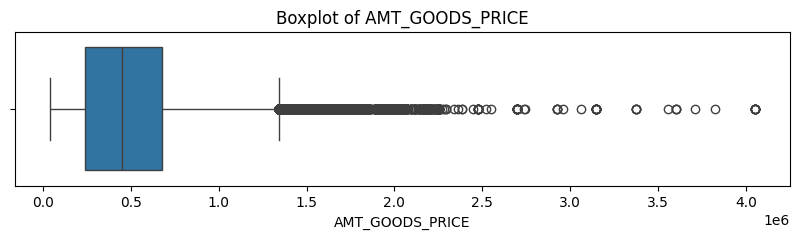

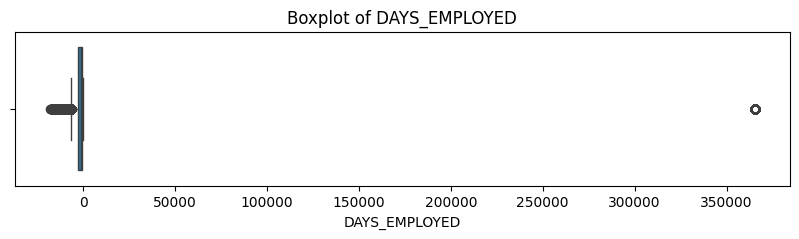

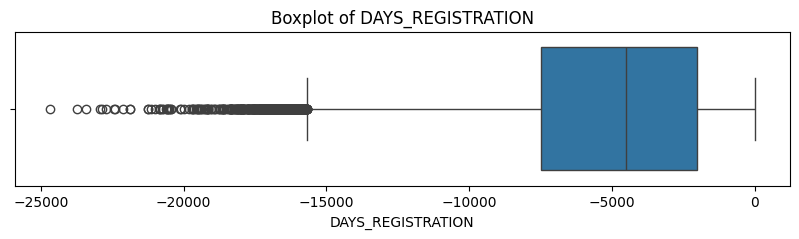

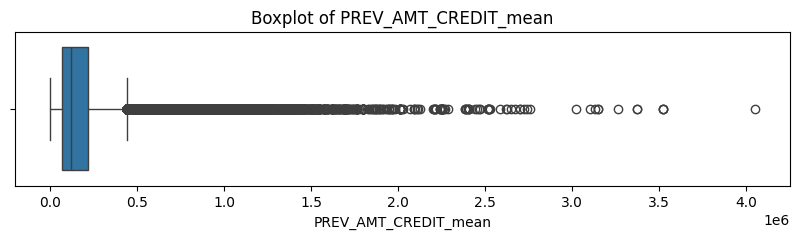

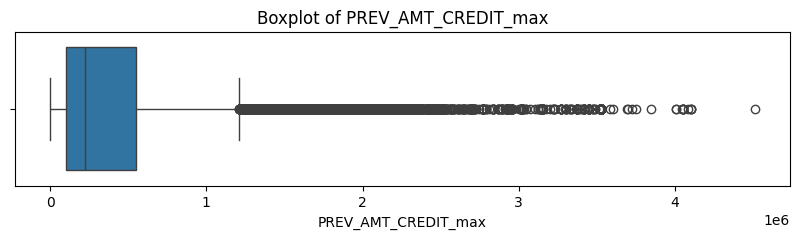

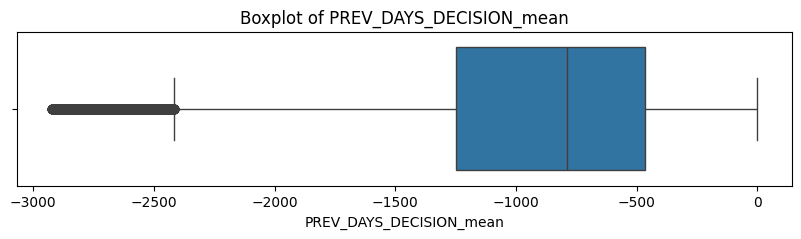

In [18]:
# Boxplot
boxplot_cols = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'PREV_AMT_CREDIT_mean',
    'PREV_AMT_CREDIT_max',
    'PREV_DAYS_DECISION_mean'
    ]

for col in boxplot_cols:
  plt.figure(figsize=(10, 2))
  sns.boxplot(x=df_merged[col], orient='h')
  plt.title(f'Boxplot of {col}')
  plt.xlabel(col)
  plt.show()

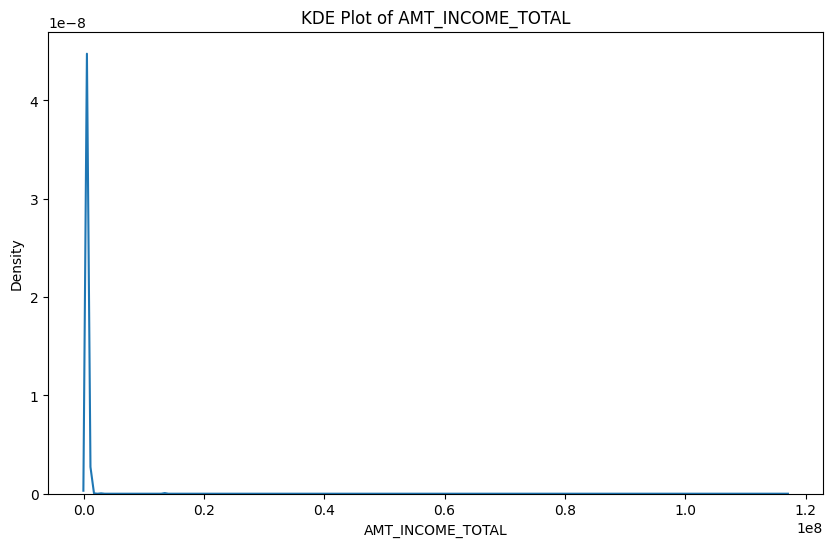

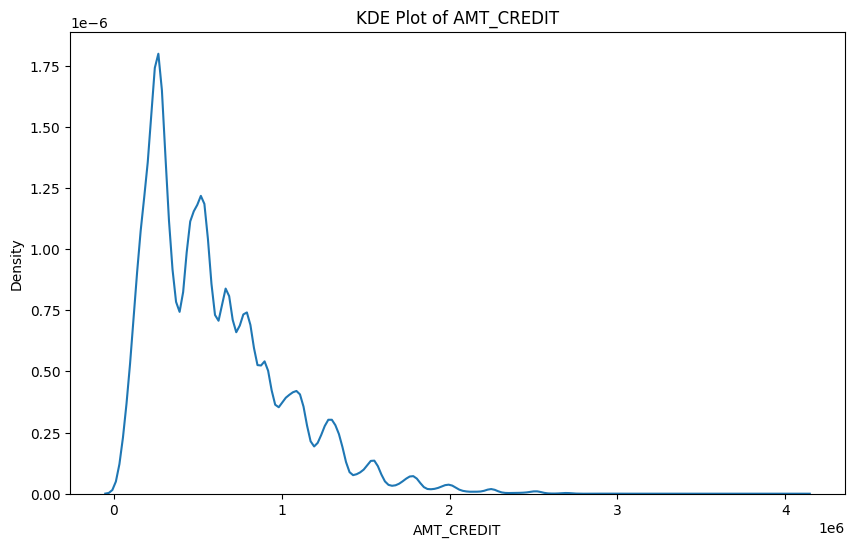

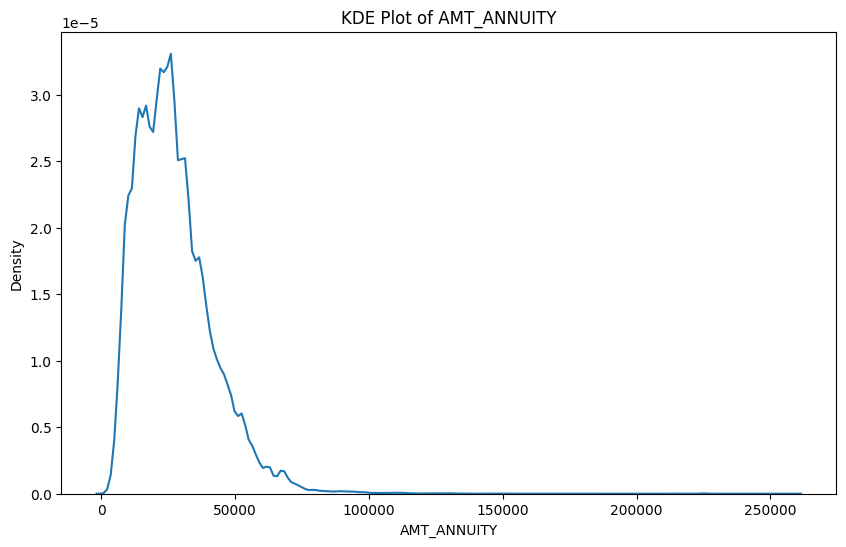

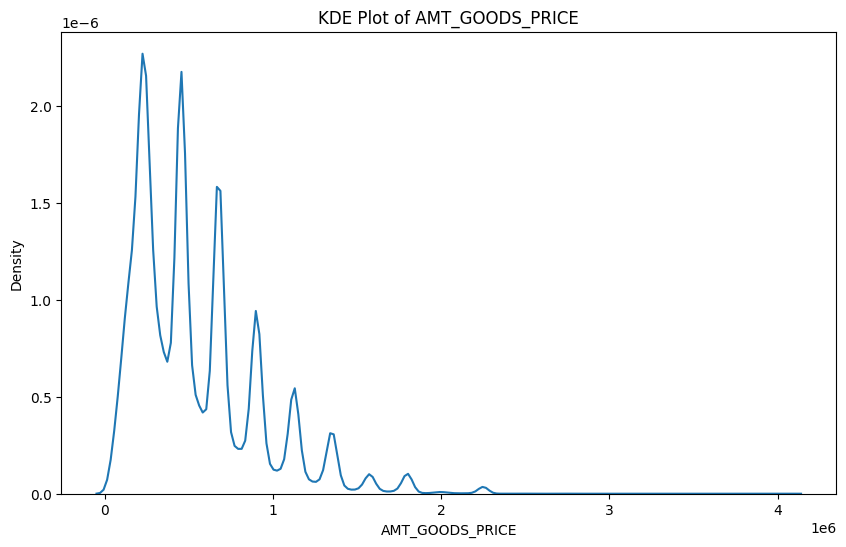

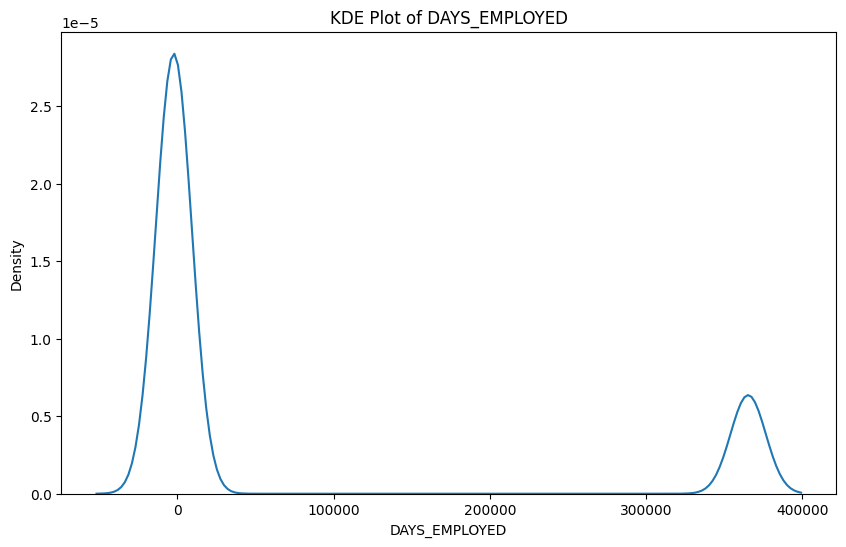

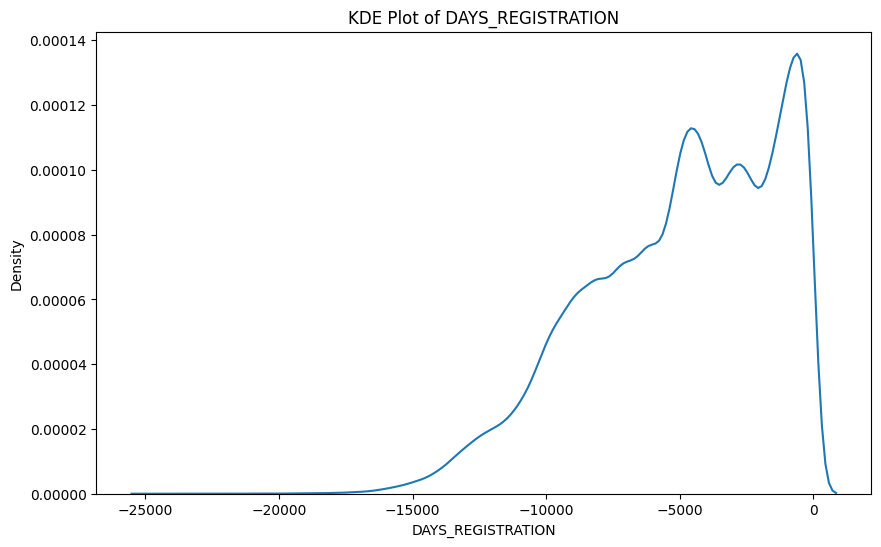

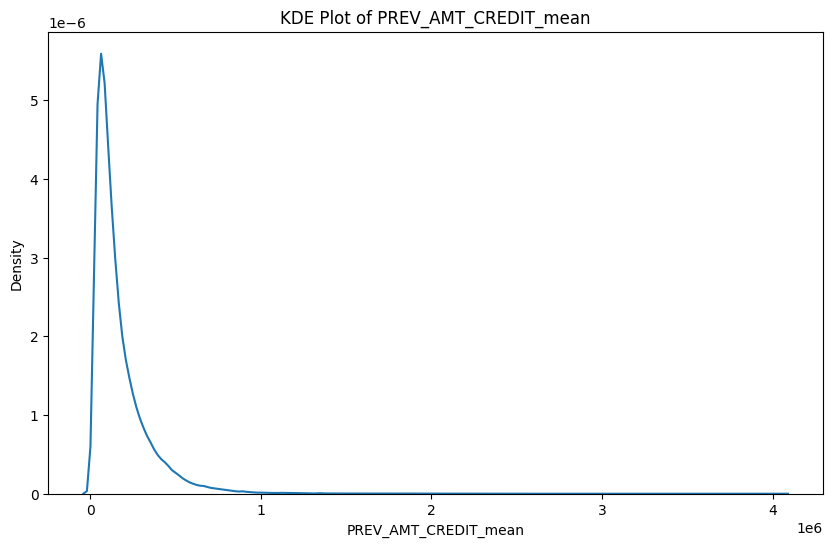

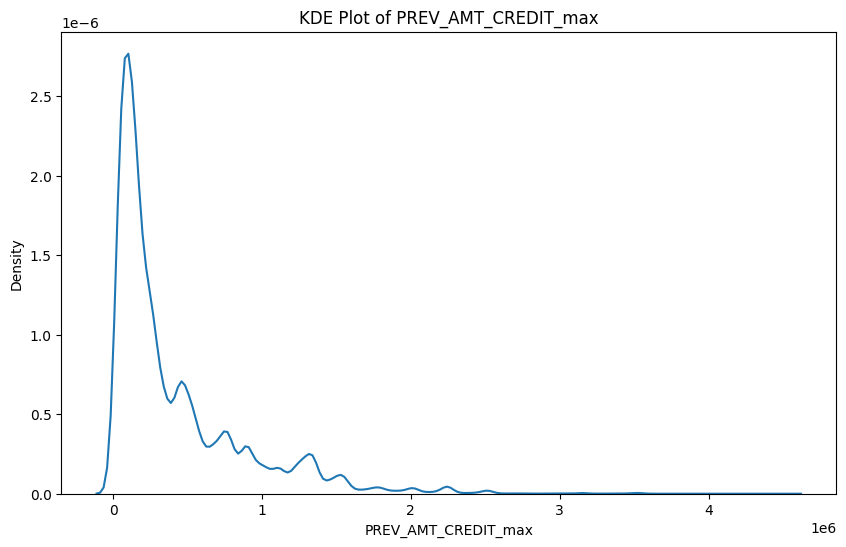

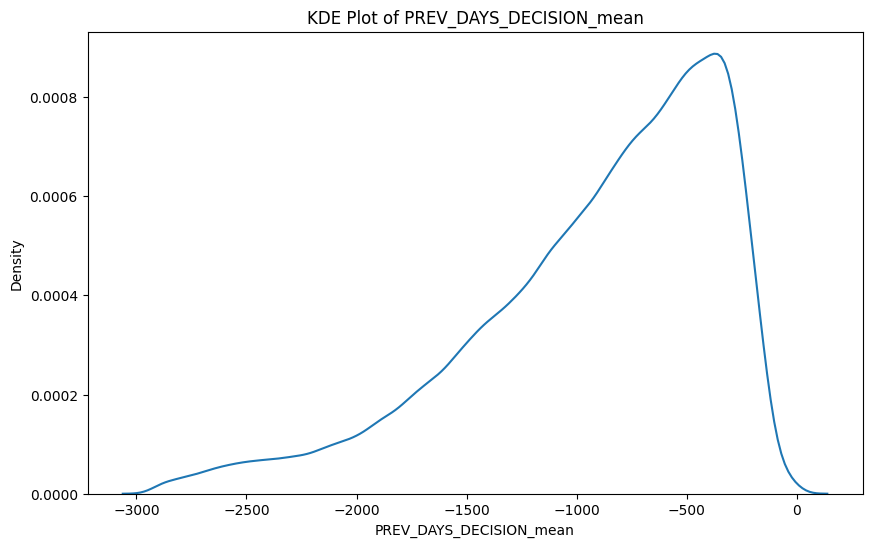

In [19]:
# KDE plot
kde_cols = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'PREV_AMT_CREDIT_mean',
    'PREV_AMT_CREDIT_max',
    'PREV_DAYS_DECISION_mean'
    ]

for col in kde_cols:
  plt.figure(figsize=(10, 6))
  sns.kdeplot(data=df_merged, x=col)
  plt.title(f'KDE Plot of {col}')
  plt.xlabel(col)
  plt.ylabel('Density')
  plt.show()

### Section 1.3: Cleaning and transformation

In [20]:
df_model = df_merged.copy()

In [21]:
# Drop rows / Basic cleaning
df_model = df_model[df_model['CODE_GENDER'] != 'XNA']
df_model = df_model.dropna(subset=['AMT_ANNUITY', 'AMT_GOODS_PRICE'])
df_model = df_model[df_model['NAME_FAMILY_STATUS'] != 'Unknown']
df_model.loc[:, 'OCCUPATION_TYPE'] = df_model['OCCUPATION_TYPE'].fillna("Unknown")

In [22]:
# Replace placeholder values and fill missing
df_model.loc[:, 'DAYS_EMPLOYED'] = df_model['DAYS_EMPLOYED'].replace(365243, np.nan)
df_model.loc[:, 'DAYS_EMPLOYED'] = df_model['DAYS_EMPLOYED'].fillna(df_model['DAYS_EMPLOYED'].median())

mode_cnt_fam_members = df_model['CNT_FAM_MEMBERS'].mode()[0]
df_model.loc[:, 'CNT_FAM_MEMBERS'] = df_model['CNT_FAM_MEMBERS'].fillna(mode_cnt_fam_members)

prev_cols = [col for col in df_model.columns if col.startswith('PREV_')]
df_model.loc[:, prev_cols] = df_model[prev_cols].fillna(0)

/var/folders/yf/mxdz93q50f13l4hy7ww_b_d00000gn/T/ipykernel_47298/637868.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -637. -1188.  -225. ... -7921. -4786. -1262.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_model.loc[:, 'DAYS_EMPLOYED'] = df_model['DAYS_EMPLOYED'].replace(365243, np.nan)


In [23]:
# Mapping categories (binary)
df_model.loc[:, 'NAME_CONTRACT_TYPE'] = df_model.loc[:, 'NAME_CONTRACT_TYPE'].map({
    'Cash loans': 0,
    'Revolving loans': 1
})
df_model.loc[:, 'CODE_GENDER'] = df_model.loc[:, 'CODE_GENDER'].map({'F': 0, 'M': 1})
df_model.loc[:, 'FLAG_OWN_CAR'] = df_model.loc[:, 'FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
df_model.loc[:, 'FLAG_OWN_REALTY'] = df_model.loc[:, 'FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})

In [24]:
# Merging categories NAME_INCOME_TYPE
df_model.loc[:, 'NAME_INCOME_TYPE'] = df_model['NAME_INCOME_TYPE'].replace({
    'Working': 'Working',
    'Commercial associate': 'Working',
    'Pensioner': 'Retired',
    'State servant': 'Public',
    'Unemployed': 'Other',
    'Student': 'Other',
    'Businessman': 'Other',
    'Maternity leave': 'Other'
})

In [25]:
# Merging categories NAME_EDUCATION_TYPE
df_model.loc[:, 'NAME_EDUCATION_TYPE'] = df_model['NAME_EDUCATION_TYPE'].replace({
    'Secondary / secondary special': 'Secondary',
    'Incomplete higher': 'Secondary',
    'Higher education': 'Higher',
    'Academic degree': 'Higher',
    'Lower secondary': 'Lower'
})

In [26]:
# Merging categories 'NAME_HOUSING_TYPE'
df_model.loc[:, 'NAME_HOUSING_TYPE'] = df_model['NAME_HOUSING_TYPE'].replace({
    'House / apartment': 'Stable',
    'Co-op apartment': 'Stable',
    'With parents': 'With parents',
    'Municipal apartment': 'Other',
    'Rented apartment': 'Other',
    'Office apartment': 'Other'
})

In [27]:
# Merging categories 'OCCUPATION_TYPE'
df_model.loc[:, 'OCCUPATION_TYPE'] = df_model['OCCUPATION_TYPE'].replace({
    'Managers': 'White collar',
    'Core staff': 'White collar',
    'High skill tech staff': 'White collar',
    'Accountants': 'White collar',
    'HR staff': 'White collar',
    'IT staff': 'White collar',

    'Sales staff': 'Service',
    'Medicine staff': 'Service',
    'Private service staff': 'Service',
    'Secretaries': 'Service',
    'Waiters/barmen staff': 'Service',

    'Laborers': 'Blue collar',
    'Drivers': 'Blue collar',
    'Cleaning staff': 'Blue collar',
    'Cooking staff': 'Blue collar',
    'Low-skill Laborers': 'Blue collar',
    'Security staff': 'Blue collar',
    'Realty agents': 'Blue collar',

    None: 'Unknown'
})

In [28]:
# Merging categories 'ORGANIZATION_TYPE'
df_model.loc[:, 'ORGANIZATION_TYPE'] = df_model['ORGANIZATION_TYPE'].replace({

    # Business and commercial
    'Business Entity Type 1': 'Business',
    'Business Entity Type 2': 'Business',
    'Business Entity Type 3': 'Business',
    'Self-employed': 'Business',

    # Public and governmental
    'Government': 'Government',
    'Police': 'Government',
    'Military': 'Government',
    'Security Ministries': 'Government',
    'Postal': 'Government',

    # Health and education
    'Medicine': 'Health/Education',
    'Kindergarten': 'Health/Education',
    'School': 'Health/Education',
    'University': 'Health/Education',

    # Trade
    'Trade: type 1': 'Trade',
    'Trade: type 2': 'Trade',
    'Trade: type 3': 'Trade',
    'Trade: type 4': 'Trade',
    'Trade: type 5': 'Trade',
    'Trade: type 6': 'Trade',
    'Trade: type 7': 'Trade',

    # Industry and construction
    'Industry: type 1': 'Industry',
    'Industry: type 2': 'Industry',
    'Industry: type 3': 'Industry',
    'Industry: type 4': 'Industry',
    'Industry: type 5': 'Industry',
    'Industry: type 6': 'Industry',
    'Industry: type 7': 'Industry',
    'Industry: type 8': 'Industry',
    'Industry: type 9': 'Industry',
    'Industry: type 10': 'Industry',
    'Industry: type 11': 'Industry',
    'Industry: type 12': 'Industry',
    'Industry: type 13': 'Industry',
    'Construction': 'Industry',

    # Transport and logistics
    'Transport: type 1': 'Transport',
    'Transport: type 2': 'Transport',
    'Transport: type 3': 'Transport',
    'Transport: type 4': 'Transport',

    # Services and others
    'Bank': 'Services',
    'Insurance': 'Services',
    'Telecom': 'Services',
    'Mobile': 'Services',
    'Electricity': 'Services',
    'Hotel': 'Services',
    'Restaurant': 'Services',
    'Culture': 'Services',
    'Realtor': 'Services',
    'Cleaning': 'Services',
    'Legal Services': 'Services',
    'Emergency': 'Services',
    'Advertising': 'Services',
    'Religion': 'Services',
    'Security': 'Services',
    'Housing': 'Services',
    'Services': 'Services',

    # Others and unknown
    'Other': 'Business',
    'XNA': 'Business'
})

In [29]:
# One-hot encoding categorical columns
df_model = pd.get_dummies(df_model, columns=[
    'NAME_FAMILY_STATUS',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE'
], drop_first=True).astype(int)

In [30]:
# Save cleaned dataset
df_model.to_csv("data/final_cleaned_data.csv", index=False)

## Section 2: Model training and evaluation

This section loads the pre-cleaned dataset and trains an XGBoost classifier.

Key steps:
- Feature engineering (CREDIT_TO_INCOME)
- Train-validation-test split with stratification
- Undersampling to reduce class imbalance
- Training with XGBoost using parameters derived from AutoML
- Evaluation using F1 score

Both the fixed threshold approach (0.25) and a dual-threshold strategy (<0.25 = low risk, >0.45 = high risk) are included.

### Section 2.1: Dataset split and undersampling

In [31]:
# Read file (final_cleaned_data.csv)
df_model = pd.read_csv("data/final_cleaned_data.csv")

In [32]:
# Show class imbalance
target_counts = df_model['TARGET'].value_counts()

print("Count of TARGET = 0:", target_counts.get(0, 0))
print("Count of TARGET = 1:", target_counts.get(1, 0))

Count of TARGET = 0: 282413
Count of TARGET = 1: 24804


In [ ]:
# Split full dataset (df_model) into 70/30
# df_train (70%) = training
# df_remaining (30%) = incoming data (12 months)
# Stratified split to keep 8% fraud in both
df_train, df_remaining = train_test_split(
    df_model,
    test_size=0.3,
    stratify=df_model['TARGET'],
    random_state=42
)

# Undersample non-fraud in training data to reach ~25% fraud
df_fraud = df_train[df_train['TARGET'] == 1]
df_nonfraud = df_train[df_train['TARGET'] == 0]

desired_ratio = 0.25
n_fraud = len(df_fraud)
n_nonfraud = int(n_fraud * (1 - desired_ratio) / desired_ratio)
df_nonfraud_sampled = df_nonfraud.sample(n=n_nonfraud, random_state=42)

# Combine and shuffle
df_train_balanced = pd.concat([df_fraud, df_nonfraud_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Final training set shape: {df_train_balanced.shape}")
print(df_train_balanced['TARGET'].value_counts(normalize=True))  # Should be ~25% fraud

Final training set shape: (69452, 55)
TARGET
0    0.75
1    0.25
Name: proportion, dtype: float64


In [34]:
# Split df_remaining into 12 incoming monthly datasets
monthly_chunk_size = len(df_remaining) // 12
incoming_data_months = {}

for i in range(12):
    start_idx = i * monthly_chunk_size
    end_idx = start_idx + monthly_chunk_size if i < 11 else len(df_remaining)
    incoming_data_months[f"month_{i+1}"] = df_remaining.iloc[start_idx:end_idx].copy()

In [ ]:
# Export df_train_balanced to CSV and incomind data to CSV in a folder (df_remaining)
df_train_balanced.to_csv("data/df_train_balanced.csv", index=False)

os.makedirs("data/df_remaining", exist_ok=True)
for month, df in incoming_data_months.items():
    df.to_csv(f"data/df_remaining/{month}.csv", index=False)

In [43]:
# Save a copy of df_train_balanced as df_training_current for future retraining (cumulative)
df_train_balanced = pd.read_csv("data/df_train_balanced.csv")
df_training_current = df_train_balanced.copy()
df_training_current.to_csv("data/df_training_current.csv", index=False)

### Section 2.2: Model training

In [7]:
# Read file (df_train_balanced.csv)
df_train_balanced = pd.read_csv("data/df_train_balanced.csv")

In [18]:
df_train_model = df_train_balanced.copy()

In [19]:
# Create new feature CREDIT_TO_INCOME
df_train_model["CREDIT_TO_INCOME"] = df_train_model["AMT_CREDIT"] / df_train_model["AMT_INCOME_TOTAL"]

# Prepare input data
X = df_train_model.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df_train_model['TARGET']

# Stratified split for train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
# Save train/test splits
joblib.dump(X_train, "data/train-test-splits/X_train.pkl")
joblib.dump(X_test, "data/train-test-splits/X_test.pkl")
joblib.dump(y_train, "data/train-test-splits/y_train.pkl")
joblib.dump(y_test, "data/train-test-splits/y_test.pkl")

['data/train-test-splits/y_test.pkl']

#### Section 2.2.1: MLJAR AutoML training

MLJAR AutoML was used in the early phase of the project to quickly compare different models and evaluate their performance. This helped save time during initial exploration.

Among all models, 7_Xgboost was labeled as the best overall, but 6_Xgboost showed the most suitable behavior for this task. So MLJAR helped identify XGBoost as the most suitable option based on the F1 score. 

However, since MLJAR models aren’t easily portable for deployment or integration with tools like FastAPI and MLflow, the model’s parameters (from 6_Xgboost) were manually reused to train a new XGBClassifier model in scikit-learn. This version could then be saved, logged, and used in the rest of the project.

Because of that, this section is only relevant for reference and can be skipped when running the full pipeline.

In [ ]:
from supervised.automl import AutoML

# Define AutoML
automl = AutoML(
    results_path="mljar_results",
    mode="Compete",
    total_time_limit=3600,
    eval_metric="f1",
    algorithms=["LightGBM", "Xgboost", "Random Forest", "Linear"],
    train_ensemble=True,
    verbose=1
)

# Train the AutoML
automl.fit(X_train, y_train)

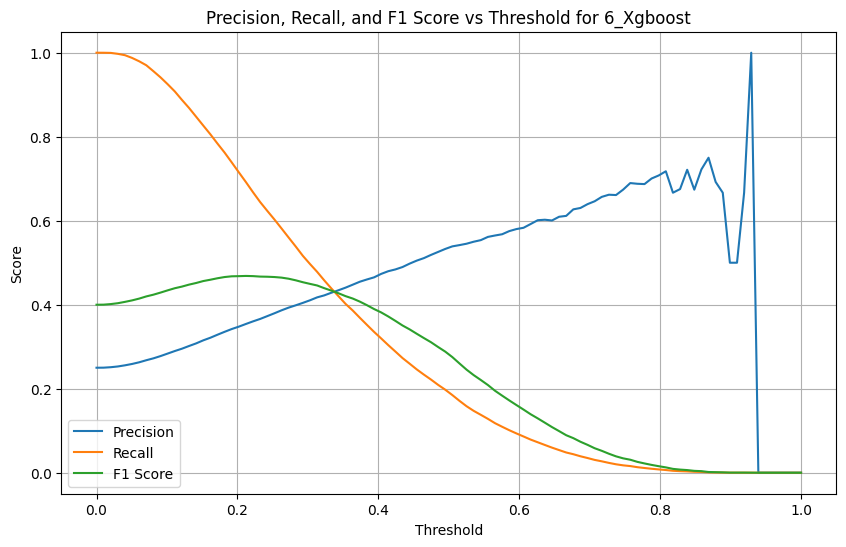

In [42]:
# Model results can be compared
chosen_model = "6_Xgboost" # '6_Xgboost' chosen as the most suitable for this task
preds_df = pd.read_csv(f"models/mljar_results/{chosen_model}/predictions_out_of_folds.csv")

# Extract values
y_val = preds_df["target"]
y_proba = preds_df["prediction"]

# Evaluate across thresholds
thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred, zero_division=0))
    recalls.append(recall_score(y_val, y_pred, zero_division=0))
    f1s.append(f1_score(y_val, y_pred, zero_division=0))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'Precision, Recall, and F1 Score vs Threshold for {chosen_model}')
plt.legend()
plt.grid(True)
plt.show()

#### Section 2.2.2: XGBClassifier training

In [43]:
# Train model using XGBoost
xgb_model = XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.1,
    max_depth=7,
    min_child_weight=25,
    subsample=0.9,
    colsample_bytree=0.6,
    n_jobs=-1,
    seed=1237,
)

xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [45]:
# Save the model
joblib.dump(xgb_model, "models/xgb_model.joblib")
print("Model saved as xgb_model.joblib")

Model saved as xgb_model.joblib


In [52]:
# Predict
y_proba = xgb_model.predict_proba(X_test)[:, 1]
# Threshold 0.215 used for comparison with MLJAR results (6_Xgboost)
# Thereshold set to 0.25 for new model
y_pred = (y_proba >= 0.25).astype(int) 

print("F1 Score:", f1_score(y_test, y_pred))

F1 Score: 0.4864162788180539


### Section 2.3: Model evaluation and Threshold tuning

In [53]:
# Load and use the model
xgb_model = joblib.load("models/xgb_model.joblib")

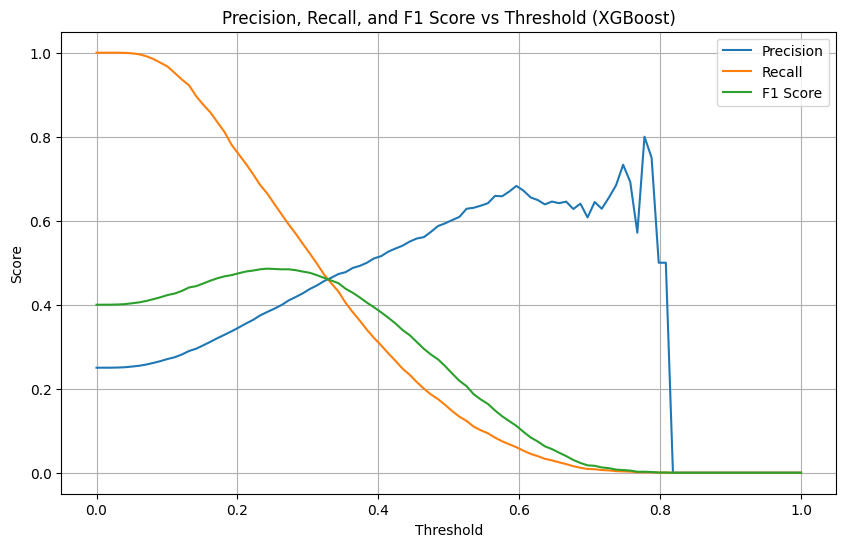

In [54]:
# Plot Precision, Recall, and F1 Score vs Threshold
thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred, zero_division=0))
    recalls.append(recall_score(y_test, y_pred, zero_division=0))
    f1s.append(f1_score(y_test, y_pred, zero_division=0))

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Print values for precision, recall and F1 score for different threshold values
thresholds_to_print = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]

print("Threshold | Precision | Recall | F1 Score")
print("------------------------------------------")

for t in thresholds_to_print:
    closest_idx = np.abs(thresholds - t).argmin()

    precision_at_t = precisions[closest_idx]
    recall_at_t = recalls[closest_idx]
    f1_at_t = f1s[closest_idx]

    print(f"{t:.2f}      | {precision_at_t:.4f}    | {recall_at_t:.4f} | {f1_at_t:.4f}")

Threshold | Precision | Recall | F1 Score
------------------------------------------
0.25      | 0.3906    | 0.6398 | 0.4851
0.30      | 0.4377    | 0.5215 | 0.4759
0.35      | 0.4776    | 0.4045 | 0.4380
0.40      | 0.5157    | 0.3032 | 0.3819
0.45      | 0.5576    | 0.2160 | 0.3113
0.50      | 0.5938    | 0.1612 | 0.2536
0.55      | 0.6359    | 0.1011 | 0.1744


In [56]:
# Create a DataFrame for inspection
preds_df = pd.DataFrame({
    "probability": y_proba,
    "true_label": y_test.reset_index(drop=True)
})

# Risk classification logic
def classify_risk(probabilities, threshold_high=0.45, threshold_moderate=0.25):
    risk_labels = []
    for prob in probabilities:
        if prob >= threshold_high:
            risk_labels.append("high_risk")
        elif prob >= threshold_moderate:
            risk_labels.append("moderate_risk")
        else:
            risk_labels.append("low_risk")
    return risk_labels

# Apply classification
preds_df["risk_level"] = classify_risk(preds_df["probability"])
print(preds_df["risk_level"].value_counts())

risk_level
low_risk         8125
moderate_risk    4358
high_risk        1408
Name: count, dtype: int64


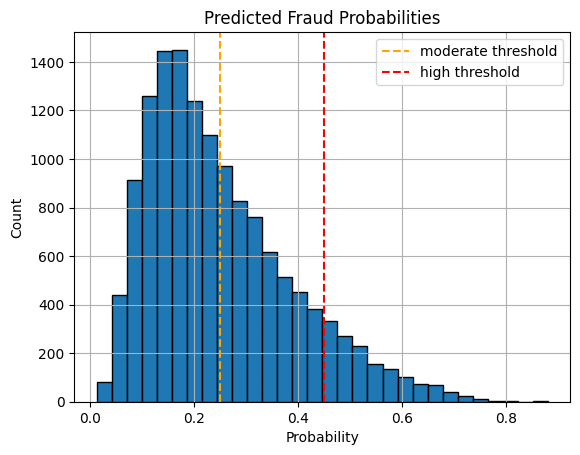

In [57]:
# Plot histogram of predicted probabilities
plt.hist(preds_df["probability"], bins=30, edgecolor='k')
plt.axvline(0.25, color='orange', linestyle='--', label='moderate threshold')
plt.axvline(0.45, color='red', linestyle='--', label='high threshold')
plt.title("Predicted Fraud Probabilities")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# Evaluate confusion matrix for "high_risk" group
y_pred_high = (preds_df["risk_level"] == "high_risk").astype(int)
cm = confusion_matrix(preds_df["true_label"], y_pred_high)
print("Confusion matrix for high-risk only:\n", cm)

Confusion matrix for high-risk only:
 [[9793  625]
 [2690  783]]


## Section 3: Model testing

In this section, the "incoming data" was used for quick testing, no influence on the trained model...

This section simulates the model’s behavior on "incoming data", previously divided into 12 monthly chunks.
It does not involve retraining, instead, it:
- Applies the model to simulated new data
- Tests the inference logic
- Validates the dual-threshold risk classification

Useful for checking consistency before full API deployment or MLOps automation.

In [2]:
# Load trained model
xgb_model = joblib.load("models/xgb_model.joblib")

In [11]:
# Assign all months to a dataframe
months_to_read = [f"data/df_remaining/month_{i}.csv" for i in range(1, 13)]
monthly_dataframes = {}
for filename in months_to_read:
    if os.path.exists(filename):
        exec(f"df_{os.path.basename(filename).replace('.csv', '')} = pd.read_csv(filename)")
        print(f"Read {filename} into dataframe df_{os.path.basename(filename).replace('.csv', '')}.")
    else:
        print(f"{filename} not found, skipping.")

Read data/df_remaining/month_1.csv into dataframe df_month_1.
Read data/df_remaining/month_2.csv into dataframe df_month_2.
Read data/df_remaining/month_3.csv into dataframe df_month_3.
Read data/df_remaining/month_4.csv into dataframe df_month_4.
Read data/df_remaining/month_5.csv into dataframe df_month_5.
Read data/df_remaining/month_6.csv into dataframe df_month_6.
Read data/df_remaining/month_7.csv into dataframe df_month_7.
Read data/df_remaining/month_8.csv into dataframe df_month_8.
Read data/df_remaining/month_9.csv into dataframe df_month_9.
Read data/df_remaining/month_10.csv into dataframe df_month_10.
Read data/df_remaining/month_11.csv into dataframe df_month_11.
Read data/df_remaining/month_12.csv into dataframe df_month_12.


In [ ]:
# Risk prediction using model and defined threshold
def predict_risk(df_month, model):
    df_month = df_month.copy()
    df_month["CREDIT_TO_INCOME"] = df_month["AMT_CREDIT"] / df_month["AMT_INCOME_TOTAL"]

    # Drop columns that shouldn't be used for prediction
    cols_to_drop = [col for col in ["SK_ID_CURR", "TARGET"] if col in df_month.columns]
    X = df_month.drop(columns=cols_to_drop)
    
    # Get probability of fraud (positive class)
    proba = model.predict_proba(X)[:, 1]

    # Assign risk levels based on probability thresholds
    risk = pd.Series("moderate_risk", index=X.index)
    risk[proba < 0.25] = "low_risk"
    risk[proba > 0.45] = "high_risk"

    # Combine probabilities and risk levels into a response list
    return [{"probability": round(p, 4), "risk_level": r} for p, r in zip(proba, risk)]

In [5]:
# Risk profile
month_files = [f"data/df_remaining/month_{i}.csv" for i in range(1, 13)]
monthly_risk_profiles = {}

for filename in month_files:
    if os.path.exists(filename):
        df_month = pd.read_csv(filename)
        print(f"\nProcessing {filename}...")

        risk_levels = predict_risk(df_month, xgb_model)
        risk_levels_series = pd.Series([item['risk_level'] for item in risk_levels])
        monthly_risk_profiles[filename] = risk_levels_series.value_counts()

        print(f"Risk profile for {filename}:\n", monthly_risk_profiles[filename])
    else:
        print(f"\n{filename} not found, skipping.")


Processing data/df_remaining/month_1.csv...
Risk profile for data/df_remaining/month_1.csv:
 low_risk         4939
moderate_risk    2152
high_risk         589
Name: count, dtype: int64

Processing data/df_remaining/month_2.csv...
Risk profile for data/df_remaining/month_2.csv:
 low_risk         4928
moderate_risk    2192
high_risk         560
Name: count, dtype: int64

Processing data/df_remaining/month_3.csv...
Risk profile for data/df_remaining/month_3.csv:
 low_risk         4896
moderate_risk    2211
high_risk         573
Name: count, dtype: int64

Processing data/df_remaining/month_4.csv...
Risk profile for data/df_remaining/month_4.csv:
 low_risk         4808
moderate_risk    2280
high_risk         592
Name: count, dtype: int64

Processing data/df_remaining/month_5.csv...
Risk profile for data/df_remaining/month_5.csv:
 low_risk         4885
moderate_risk    2266
high_risk         529
Name: count, dtype: int64

Processing data/df_remaining/month_6.csv...
Risk profile for data/df_

In [6]:
# Evaluate confusion matrix for each month
def evaluate_confusion_matrix(df, actual_col, predicted_col, risk_level):
    binary_actual = df[actual_col]
    binary_predicted = (df[predicted_col] == risk_level).astype(int)
    return confusion_matrix(binary_actual, binary_predicted)

months = [1, 2, 3]
risk_levels = ["low_risk", "moderate_risk", "high_risk"]

for i in months:
    df_month = pd.read_csv(f"data/df_remaining/month_{i}.csv")
    predictions = predict_risk(df_month, xgb_model)
    df_month["predicted_risk"] = [p["risk_level"] for p in predictions]

    print(f"\n--- Confusion Matrices for month_{i} ---")
    for risk in risk_levels:
        cm = evaluate_confusion_matrix(df_month, "TARGET", "predicted_risk", risk)
        print(f"Confusion Matrix for {risk}:")
        print(cm)
        print("-" * 20)


--- Confusion Matrices for month_1 ---
Confusion Matrix for low_risk:
[[2338 4719]
 [ 403  220]]
--------------------
Confusion Matrix for moderate_risk:
[[5156 1901]
 [ 372  251]]
--------------------
Confusion Matrix for high_risk:
[[6620  437]
 [ 471  152]]
--------------------

--- Confusion Matrices for month_2 ---
Confusion Matrix for low_risk:
[[2371 4681]
 [ 381  247]]
--------------------
Confusion Matrix for moderate_risk:
[[5112 1940]
 [ 376  252]]
--------------------
Confusion Matrix for high_risk:
[[6621  431]
 [ 499  129]]
--------------------

--- Confusion Matrices for month_3 ---
Confusion Matrix for low_risk:
[[2406 4664]
 [ 378  232]]
--------------------
Confusion Matrix for moderate_risk:
[[5106 1964]
 [ 363  247]]
--------------------
Confusion Matrix for high_risk:
[[6628  442]
 [ 479  131]]
--------------------


In [12]:
# Output the first row of df_month_1 as JSON
# Use output for testing API responses
first_row_dict = df_month_1.iloc[0].to_dict()
output_json = {"data": [first_row_dict]}

print(json.dumps(output_json, indent=2))

{
  "data": [
    {
      "SK_ID_CURR": 212200,
      "TARGET": 0,
      "NAME_CONTRACT_TYPE": 1,
      "CODE_GENDER": 0,
      "FLAG_OWN_CAR": 0,
      "FLAG_OWN_REALTY": 1,
      "CNT_CHILDREN": 0,
      "AMT_INCOME_TOTAL": 122850,
      "AMT_CREDIT": 270000,
      "AMT_ANNUITY": 13500,
      "AMT_GOODS_PRICE": 270000,
      "DAYS_BIRTH": -21078,
      "DAYS_EMPLOYED": -13168,
      "DAYS_REGISTRATION": -1162,
      "CNT_FAM_MEMBERS": 1,
      "FLAG_EMP_PHONE": 1,
      "FLAG_WORK_PHONE": 0,
      "FLAG_CONT_MOBILE": 1,
      "FLAG_EMAIL": 0,
      "REGION_RATING_CLIENT": 2,
      "REG_REGION_NOT_LIVE_REGION": 0,
      "PREV_AMT_CREDIT_mean": 63758,
      "PREV_AMT_CREDIT_max": 254340,
      "PREV_CNT_PAYMENT_mean": 18,
      "PREV_NFLAG_LAST_APPL_IN_DAY_sum": 7,
      "PREV_DAYS_DECISION_mean": -416,
      "PREV_NAME_CONTRACT_STATUS_Approved_sum": 1,
      "PREV_NAME_CONTRACT_STATUS_Refused_sum": 2,
      "PREV_NAME_CONTRACT_STATUS_Canceled_sum": 4,
      "PREV_NAME_CONTRACT_STATUS_